# QAOA (Quantum Approximate Optimization Algorithm)
#### Max-Cut Problem Implementation from the Qiskit Textbook

In [16]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import Aer, execute
from qiskit import IBMQ
from qiskit.compiler import transpile
from time import perf_counter
import pprint

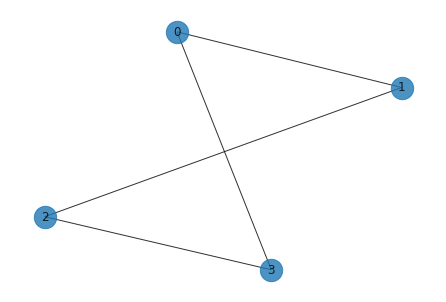

In [17]:
#Creating the Graph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3])
G.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(G, with_labels=True, alpha=0.8, node_size=500)

#### Initialization

In [18]:
#Initialization
from qiskit.circuit import Parameter

adjacency = nx.adjacency_matrix(G).todense()
numqubits = 4
beta = Parameter("$\\beta$")
gamma = Parameter("$\\gamma$")

qc_0 = QuantumCircuit(numqubits)
qc_mix = QuantumCircuit(numqubits)
qc_cost = QuantumCircuit(numqubits)

C:\Users\vibus\AppData\Local\Temp\ipykernel_32492\1401053198.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency = nx.adjacency_matrix(G).todense()


#### Building the Basic Circuit

Circuit construction took 0.0058391999918967485 sec.


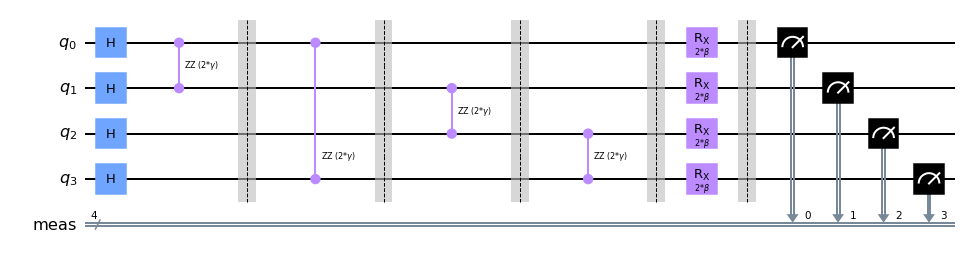

In [19]:
start = perf_counter()

#Setting the Initial State
for i in range(0, numqubits):
    qc_0.h(i)

#Applying the Mixing Unitary
for i in range(0, numqubits):
    qc_mix.rx(2 * beta, i)

#Applying the Cost Unitary
for pair in list(G.edges()):  # pairs of nodes
    qc_cost.rzz(2 * gamma, pair[0], pair[1])
    qc_cost.barrier()

qc_qaoa = QuantumCircuit(numqubits)
qc_qaoa.append(qc_0, [i for i in range(0, numqubits)])
qc_qaoa.append(qc_cost, [i for i in range(0, numqubits)])
qc_qaoa.append(qc_mix, [i for i in range(0, numqubits)])

qc_qaoa.measure_all()

end = perf_counter()

print(f"Circuit construction took {(end - start)} sec.")
qc_qaoa.decompose().draw(output='mpl')

#### Building the Parameterized Circuit

In [20]:
def create_qaoa_circ(G, theta):
    
    """
    Creates a parametrized qaoa circuit
    
    Args:  
        G: networkx graph
        theta: a list of paramters for the unitaries

    Returns:
        qc: qiskit circuit
    """
    numqubits = len(G.nodes())
    p = len(theta)//2  # number of alternating unitary iterations
    qc = QuantumCircuit(numqubits)
    
    beta = theta[:p]
    gamma = theta[p:]
    
    # initial_state
    for i in range(0, numqubits):
        qc.h(i)
    
    for iteration in range(0, p):
        
        # problem unitary
        for pair in list(G.edges()):
            qc.rzz(2 * gamma[iteration], pair[0], pair[1])

        # mixer unitary
        for i in range(0, numqubits):
            qc.rx(2 * beta[iteration], i)
            
    qc.measure_all()

    return qc


### Implementing the Classical Optimization

#### Helper Functions for Classically Optimized Parameters

In [21]:
def maxcut_obj(x, G):
    """
    Given a bitstring as a solution, this function returns
    the number of edges shared between the two partitions
    of the graph.
    
    Args:
        x: str
           solution bitstring
           
        G: networkx graph
        
    Returns:
        obj: float
             Objective
    """
    obj = 0
    for i, j in G.edges():
        if x[i] != x[j]:
            #It seems counter-intutive, but the goal is to minimize the objective we measure, 
            #so we are favoring these edges using a negative 1.
            obj -= 1
            
    return obj
    
def compute_expectation(counts, G):
    
    """
    Computes expectation value based on measurement results
    
    Args:
        counts: dict
                key as bitstring, val as count
           
        G: networkx graph
        
    Returns:
        avg: float
             expectation value (how many cuts will be made)
    """
    
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        
        obj = maxcut_obj(bitstring, G)
        avg += obj * count
        sum_count += count
    
    #returns the expected amount of cuts those measurement results
    return avg/sum_count

In [22]:
def get_expectation(G, p, shots=512):
    
    """
    Runs parametrized circuit
    
    Args:
        G: networkx graph
        p: int,
           Number of repetitions of unitaries
    """
    
    backend = Aer.get_backend('qasm_simulator')
    backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(G, theta)
        #seed simulator controls the random sampling from a simulator
        counts = backend.run(qc, seed_simulator=10, 
                             nshots=512).result().get_counts()
        
        return compute_expectation(counts, G)
    
    return execute_circ

In [23]:
from scipy.optimize import minimize

expectation = get_expectation(G, p=3)

result = minimize(expectation, 
                      [1.0, 1.0], 
                      method='COBYLA')
result
print(result.x)


[1.9793337  1.16663483]


### Executing the Optimized Circuit

#### Resource Estimation on a Simulator

Paramterized Circuit construction took 0.00046090001706033945 sec.
Width: 4 qubits
Depth: 6
Gate counts: OrderedDict([('h', 4), ('rzz', 4), ('rx', 4), ('measure', 4), ('barrier', 1)])


C:\Users\vibus\AppData\Local\Temp\ipykernel_32492\1894386775.py:16: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  active_qubits[qubit.index] = True


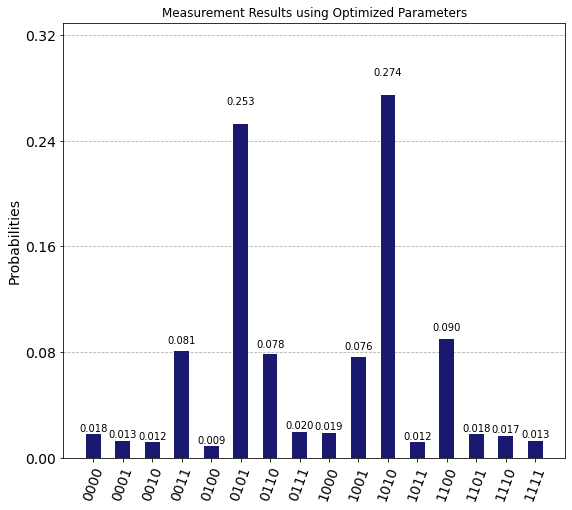

In [25]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
backend.shots = 512

#using the optimized parameters for the circuit
start = perf_counter()
qc_res = create_qaoa_circ(G, result.x)
end = perf_counter()
print(f"Paramterized Circuit construction took {(end - start)} sec.")

active_qubits = {}
for op in qc_res.data: 
    if op[0].name != "barrier" and op[0].name != "snapshot": 
        for qubit in op[1]: 
            active_qubits[qubit.index] = True

print(f"Width: {len(active_qubits)} qubits")
print(f"Depth: {qc_res.depth()}")
print(f"Gate counts: {qc_res.count_ops()}")
#pprint.pprint(qc_res.count_ops(), sort_dicts=False)

counts = backend.run(qc_res, seed_simulator=10).result().get_counts()
plot_histogram(counts, figsize = (9,8), color='midnightblue', title="Measurement Results using Optimized Parameters")

#### Resource Estimation on an IBM Quantum Computer

In [10]:
provider = IBMQ.load_account()
#print(provider.backends(None, None))
machine = "ibm_nairobi"
backend = provider.get_backend(machine)

In [11]:
#Preparation
print(f"Transpiling for {machine}...")
start = perf_counter()
result_circuit = transpile(qc_res, backend=backend, optimization_level=1)
end = perf_counter()
print(f"Compiling and optimizing the parameterized circuit took {(end - start)} sec.")

active_qubits = {}
for op in result_circuit.data: 
    if op[0].name != "barrier" and op[0].name != "snapshot": 
        for qubit in op[1]: 
            active_qubits[qubit.index] = True
print(f"Width: {len(active_qubits)} qubits")
print(f"Depth: {result_circuit.depth()}")
print(f"Gate counts: {result_circuit.count_ops()}")

Transpiling for ibm_nairobi...
Compiling and optimizing the parameterized circuit took 1.5542460000142455 sec.
Width: 4 qubits
Depth: 27
Gate counts: OrderedDict([('rz', 24), ('cx', 14), ('sx', 12), ('measure', 4), ('barrier', 1)])


C:\Users\vibus\AppData\Local\Temp\ipykernel_32492\3308296823.py:11: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  active_qubits[qubit.index] = True


In [26]:
#Execution
run = execute(result_circuit, backend, shots=512)
result = run.result()
counts = result.get_counts(result_circuit)

for (measured_state, count) in counts.items(): 
    big_endian_state = measured_state[::-1]
    print(f"Measured {big_endian_state} {count} times.")

Measured 1111 9 times.
Measured 0101 142 times.
Measured 1001 45 times.
Measured 1100 42 times.
Measured 1010 134 times.
Measured 0111 9 times.
Measured 0010 6 times.
Measured 0100 13 times.
Measured 0110 39 times.
Measured 0011 35 times.
Measured 1110 7 times.
Measured 1011 7 times.
Measured 0000 7 times.
Measured 1000 6 times.
Measured 0001 5 times.
Measured 1101 6 times.


### Noise Model

In [12]:
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

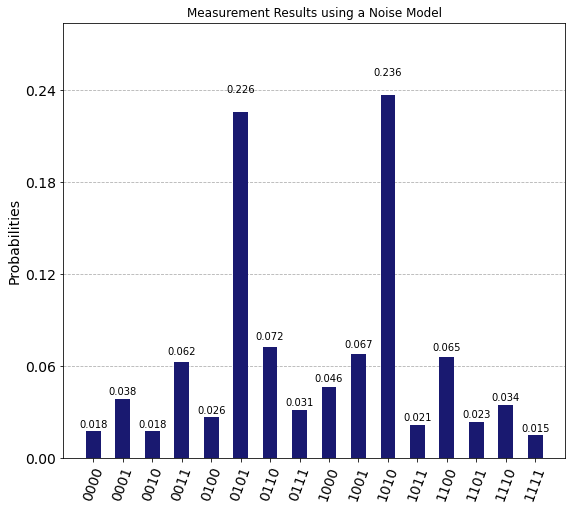

In [14]:
# Building noise models from backend properties
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# print(Aer.backends())

# Perform a noise simulation
result = execute(result_circuit, Aer.get_backend('aer_simulator'),
                 coupling_map=coupling_map,
                 basis_gates=basis_gates,
                 noise_model=noise_model).result()
counts = result.get_counts(0)
plot_histogram(counts, figsize = (9,8), color='midnightblue', title="Measurement Results using a Noise Model")